In [1]:
import deepblink as pink
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io
import trackpy as tp

tp.quiet()

In [2]:
!deepblink download -i particle

# Tracking: combining predictions from single frames

deepBlink is only able to predict on a single 2D image at a time. Therefore, additional tools have to be used if tracking (the linking of single particles across time) should be performed.

Here we will use [trackpy](http://soft-matter.github.io/trackpy/dev/index.html) to do most of the heavy lifting.

### Step 1: Loading image and model

First, lets begin by loading a pre-trained model and example image into memory using deepBlink and scikit-image respectively.

In [3]:
image = skimage.io.imread("./image.tif")
image.shape

(16, 512, 512)

In [4]:
model = pink.io.load_model("./particle.h5")

### Step 2: Spot detection

Next, we can go through all frames individually using the `deepblink.inference.predict` function. We will save all predictions into a single `pandas.DataFrame` to which we'll add the current frame.

To gather some data on each spot, we can use `trackpy.refine_com` to get the following:
* `mass`: total integrated brightness of the blob
* `size`: radius of gyration of its Gaussian-like profile
* `ecc`: eccentricity (0 is circular)
* `signal`: intensity of signal
* `raw_mass`: total integrated brightness (raw image)

We don't want to refine the spots so we subsequently replace the x and y columns.

In [5]:
do_refinement = True
radius_refinement = 3

In [6]:
df = pd.DataFrame()

for frame, image_curr in enumerate(image):
    # deepBlink prediction
    yx = pink.inference.predict(image=image_curr, model=model)
    y, x = yx.T

    if do_refinement:
        # Optional refinement with trackpy
        df_curr = tp.refine_com(
            raw_image=image_curr, image=image_curr, radius=radius_refinement, coords=yx
        )
        df_curr["x"] = x
        df_curr["y"] = y
        df_curr["frame"] = frame
    else:
        df_curr = pd.DataFrame(dict(x=x, y=y, frame=frame))
    df = df.append(df_curr, ignore_index=True)

df

,y,x,mass,size,ecc,signal,raw_mass,frame
0,25.646482,58.133535,859.0,2.044898,0.075699,48.0,859.0,0
1,26.968888,89.922246,868.0,2.051188,0.039871,46.0,868.0,0
2,26.600582,178.641128,864.0,2.050858,0.033927,45.0,864.0,0
3,27.285306,364.561546,817.0,2.007331,0.086879,49.0,817.0,0
4,27.732803,385.838732,881.0,2.022855,0.039481,46.0,881.0,0
...,...,...,...,...,...,...,...,...
4154,481.948925,272.684405,885.0,2.063402,0.072653,49.0,885.0,15
4155,481.832175,363.418543,895.0,1.997484,0.103791,57.0,895.0,15
4156,483.724480,391.803127,872.0,1.993683,0.092126,50.0,872.0,15
4157,480.534182,449.081930,828.0,2.038281,0.057931,42.0,828.0,15


We can now plot the predictions to have a look. This can be done using basic `matplotlib.pyplot.scatter` or using `tp.annotate`.

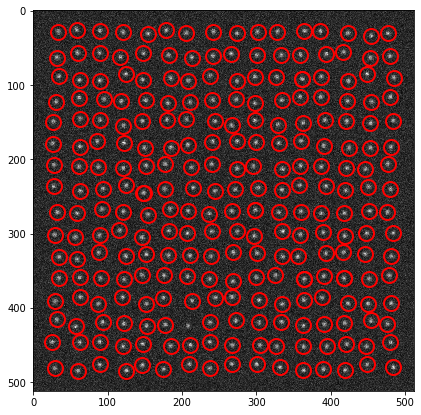

In [7]:
plt.figure(figsize=(7, 7))
tp.annotate(df[df["frame"] == 0], image[0]);

The last thing before tracking is to make sure we don't have a subpixel bias. This can easily be visualized using `trackpy.subpx_bias`.

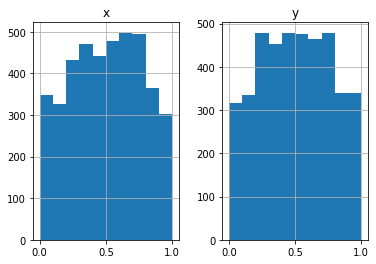

In [8]:
tp.subpx_bias(df);

### Step 3: Tracking

There are two main methods of linking / tracking:
1. The basic `trackpy.link` command using a browninan motion predictor.
1. One relying on algorithms such as the `trackpy.predict.NearestVelocityPredict` class. NearestVelocity takes the previous time points into account and extrapolates their relative velocities.

Subsequently we can filter spurious trajectories that are considered too short using `trackpy.filter_stubs`. Both are shown below.

In [9]:
search_range = 10
gap_frames = 5
min_frames = 2

In [10]:
# Option 1
track = tp.link(df, search_range=search_range, memory=gap_frames)
track = tp.filter_stubs(track, threshold=min_frames)

In [11]:
# Option 2
pred = tp.predict.NearestVelocityPredict()
track = pred.link_df(df, search_range=search_range, memory=gap_frames)
track = tp.filter_stubs(track, threshold=min_frames)
track

,y,x,mass,size,ecc,signal,raw_mass,frame,particle
frame,,,,,,,,,
0,25.646482,58.133535,859.0,2.044898,0.075699,48.0,859.0,0,0
0,26.968888,89.922246,868.0,2.051188,0.039871,46.0,868.0,0,1
0,26.600582,178.641128,864.0,2.050858,0.033927,45.0,864.0,0,2
0,27.285306,364.561546,817.0,2.007331,0.086879,49.0,817.0,0,3
0,27.732803,385.838732,881.0,2.022855,0.039481,46.0,881.0,0,4
...,...,...,...,...,...,...,...,...,...
15,481.948925,272.684405,885.0,2.063402,0.072653,49.0,885.0,15,329
15,481.832175,363.418543,895.0,1.997484,0.103791,57.0,895.0,15,255
15,483.724480,391.803127,872.0,1.993683,0.092126,50.0,872.0,15,256


Trackpy also allows easy visualization of tracks using `tp.plot_traj`.

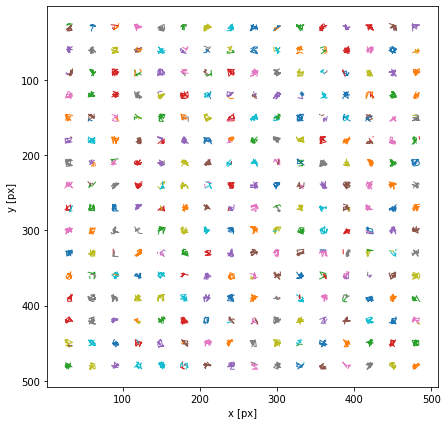

In [12]:
plt.figure(figsize=(7, 7))
tp.plot_traj(track);

Additionally, we can plot the size vs. mass and subsequently filter out unwanted trajectories using basic pandas slicing (ommited).

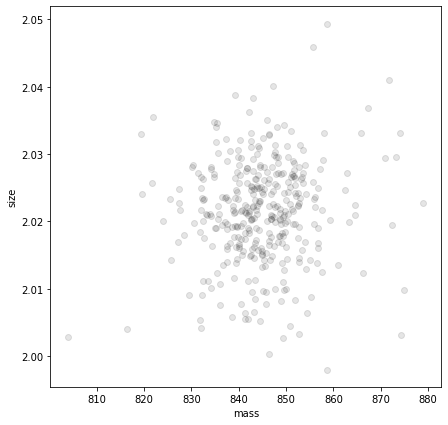

In [13]:
plt.figure(figsize=(7, 7))
tp.mass_size(track.groupby("particle").mean());

In [14]:
# track = track[((track["mass"] > 50) & (track["size"] < 2.6) & (track["ecc"] < 0.3))]

It is likely that the entire specimen moves around (e.g. bump at the microscope) which we want to correct for. This is called drift. We can calculate it using `trackpy.compute_drift` (average displacement). Subsequently, drift is removed using `trackpy.substract_drift`.

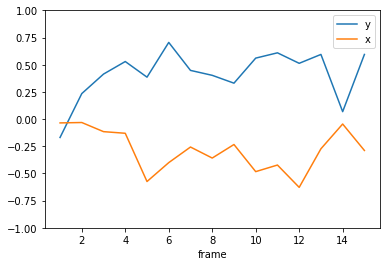

In [15]:
drift = tp.compute_drift(track)
drift.plot()
plt.ylim(-1, 1);

In [16]:
trackd = tp.subtract_drift(track.copy(), drift)
trackd

,y,x,mass,size,ecc,signal,raw_mass,frame,particle
frame,,,,,,,,,
0,25.646482,58.133535,859.0,2.044898,0.075699,48.0,859.0,0,0
0,26.968888,89.922246,868.0,2.051188,0.039871,46.0,868.0,0,1
0,26.600582,178.641128,864.0,2.050858,0.033927,45.0,864.0,0,2
0,27.285306,364.561546,817.0,2.007331,0.086879,49.0,817.0,0,3
0,27.732803,385.838732,881.0,2.022855,0.039481,46.0,881.0,0,4
...,...,...,...,...,...,...,...,...,...
15,481.354536,272.973151,885.0,2.063402,0.072653,49.0,885.0,15,329
15,481.237786,363.707289,895.0,1.997484,0.103791,57.0,895.0,15,255
15,483.130091,392.091872,872.0,1.993683,0.092126,50.0,872.0,15,256


If we compute the drift again, we will see that it's at zero. Subsequent velocity and trajectory calculations will now be more accurate due to removing this global movement.

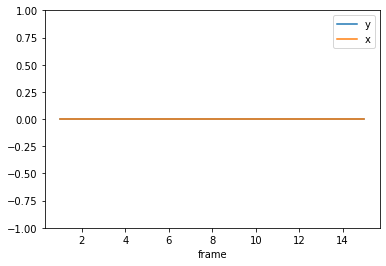

In [17]:
drift = tp.compute_drift(trackd)
drift.plot()
plt.ylim(-1, 1);

### Summary

`trackd` is the final DataFrame of trajectories and spots that can be used in subsequent analysis such as static/motion analyses (see `trackpy.imsd/emsd` and API reference), track colocalization analyses and many more.